In [1]:
!pip install --upgrade --force-reinstall numpy==1.26.4 scipy==1.10.1 scikit-learn==1.5.0 pandas==2.2.1 tensorflow==2.17.0


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 88.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.1/34.1 MB 54.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 110.6 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 106.5 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.3/601.3 MB 2.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 90.2 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 90.4 MB/s eta 

In [2]:
import numpy as np
import scipy
import sklearn
import pandas as pd
import tensorflow as tf

print(f"Numpy: {np.__version__}")
print(f"Scipy: {scipy.__version__}")
print(f"Scikit-Learn: {sklearn.__version__}")
print(f"Pandas: {pd.__version__}")
print(f"TensorFlow: {tf.__version__}")


2025-05-05 13:53:22.895030: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-05 13:53:22.917184: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-05 13:53:22.923777: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Numpy: 1.26.4
Scipy: 1.10.1
Scikit-Learn: 1.5.0
Pandas: 2.2.1
TensorFlow: 2.17.0


In [3]:
import numpy as np
import pandas as pd
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import class_weight
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau
from deap import base, creator, tools, algorithms
from skopt import BayesSearchCV
from skopt.space import Integer, Real
from sklearn.base import BaseEstimator, ClassifierMixin

In [4]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/newdoubleddataset-csv/doubled dataset.csv


In [5]:
file_path = "/kaggle/input/newdoubleddataset-csv/doubled dataset.csv"
df = pd.read_csv(file_path)
print("Dataset Shape:", df.shape)
df.head()

# Split features and target
X = df.drop(columns=['target']).values
y = df['target'].values

# Apply Min-Max Scaling
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

Dataset Shape: (2380, 12)


In [6]:
import random
from deap import base, creator, tools, algorithms
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Define Fitness Function
def fitness(individual):
    selected_features = [i for i, val in enumerate(individual) if val == 1]
    if len(selected_features) == 0:
        return 0,  # Avoid division by zero

    X_train_selected = X_train[:, selected_features]
    X_test_selected = X_test[:, selected_features]

    # Define Neural Network Model
    model = Sequential([
        Dense(16, activation='relu', input_shape=(len(selected_features),)),
        Dense(8, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
    model.fit(X_train_selected, y_train, epochs=20, verbose=0, batch_size=16)

    acc = model.evaluate(X_test_selected, y_test, verbose=0)[1]
    return acc,

# Define Genetic Algorithm Setup
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=X_train.shape[1])
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
toolbox.register("select", tools.selBest)

# Run ACO for Feature Selection
population = toolbox.population(n=10)
algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=50, verbose=True)

# Get Best Features
#best_features = [i for i, val in enumerate(tools.selBest(population, 1)[0]) if val == 1]
#X_train_selected = X_train[:, best_features]
#X_test_selected = X_test[:, best_features]

# Instead of ACO-selected features, use all features
X_train_selected = X_train  # Use all features
X_test_selected = X_test


from sklearn.utils import class_weight
import numpy as np

# Compute class weights for class imbalance
class_weights = class_weight.compute_class_weight(
    class_weight="balanced",
    classes=np.unique(y_train),
    y=y_train
)

# Convert to dictionary format
class_weight_dict = dict(enumerate(class_weights))

# Print class weights for debugging
print("Class Weights:", class_weight_dict)



/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1746453207.707822      74 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355


gen	nevals
0  	10    
1  	5     
2  	3     
3  	5     
4  	6     
5  	5     
6  	6     
7  	7     
8  	8     
9  	7     
10 	6     
11 	8     
12 	6     
13 	8     
14 	6     
15 	7     
16 	6     
17 	5     
18 	8     
19 	5     
20 	9     
21 	9     
22 	1     
23 	8     
24 	5     
25 	2     
26 	4     
27 	7     
28 	8     
29 	6     
30 	8     
31 	4     
32 	3     
33 	3     
34 	7     
35 	3     
36 	6     
37 	6     
38 	7     
39 	5     
40 	6     
41 	6     
42 	6     
43 	7     
44 	4     
45 	4     
46 	6     
47 	9     
48 	4     
49 	9     
50 	7     
Class Weights: {0: 1.0450054884742042, 1: 0.9587109768378651}


In [7]:
from imblearn.over_sampling import SMOTE

# Resample after feature selection
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_selected, y_train)


In [8]:
# Reshape for CNN (samples, timesteps, channels)
X_train_cnn = np.expand_dims(X_train_resampled, axis=-1)
X_test_cnn = np.expand_dims(X_test_selected, axis=-1)



In [9]:
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dropout, Flatten, Dense, BatchNormalization, Input
from keras.optimizers import Adam

def build_cnn_model(input_shape, learning_rate=0.001):
    model = Sequential()
    model.add(Input(shape=input_shape))  # Use Input layer to avoid warnings

    model.add(Conv1D(64, kernel_size=3, activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(0.3))

    model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))  # Use padding to avoid negative dims
    model.add(BatchNormalization())
    model.add(Flatten())

    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model


In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
# Example format (from previous optimization run)
best_params = {'learning_rate': 0.005}
best_learning_rate = best_params['learning_rate'] * 0.1  # Optional scaling

# Extract learning rate from Bayesian Optimization and tune
best_learning_rate = best_params['learning_rate'] * 0.1

# Define callbacks
checkpoint = ModelCheckpoint("best_cnn_model.keras", save_best_only=True, monitor="val_accuracy", verbose=1)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=10, min_lr=1e-7, verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss', patience=20, restore_best_weights=True, verbose=1
)


In [11]:
from sklearn.model_selection import train_test_split

# Assuming X_train_cnn and y_train_resampled are your full training set
X_train_cnn, X_val_cnn, y_train_resampled, y_val = train_test_split(
    X_train_cnn, y_train_resampled, test_size=0.2, random_state=42, stratify=y_train_resampled
)


In [35]:
cnn_model = build_cnn_model(input_shape=X_train_cnn.shape[1:], learning_rate=best_learning_rate)

history = cnn_model.fit(
    X_train_cnn, y_train_resampled,
    validation_data=(X_val_cnn, y_val),
    epochs=2400,
    batch_size=32,
    verbose=1
)

Epoch 1/2400
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.6814 - loss: 0.6371 - val_accuracy: 0.5553 - val_loss: 0.6618
Epoch 2/2400
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7839 - loss: 0.4818 - val_accuracy: 0.5000 - val_loss: 0.6675
Epoch 3/2400
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8033 - loss: 0.4549 - val_accuracy: 0.5000 - val_loss: 0.7069
Epoch 4/2400
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8098 - loss: 0.4370 - val_accuracy: 0.5000 - val_loss: 0.7381
Epoch 5/2400
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8026 - loss: 0.4291 - val_accuracy: 0.5000 - val_loss: 0.7139
Epoch 6/2400
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8062 - loss: 0.4506 - val_accuracy: 0.5276 - val_loss: 0.6795
Epoch 7/2400
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8310 - loss: 0.4002 - val_accuracy: 0.6281 - val_loss: 0.6128
Epoch 8/2400
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8055 - loss: 0.4405 - val_accuracy: 0

In [36]:
from sklearn.metrics import accuracy_score

# Predict on test set
y_pred = (cnn_model.predict(X_test_cnn) > 0.5).astype("int32")
accuracy = accuracy_score(y_test, y_pred)

print("CNN Test Accuracy:", accuracy)


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
CNN Test Accuracy: 0.9516806722689075


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


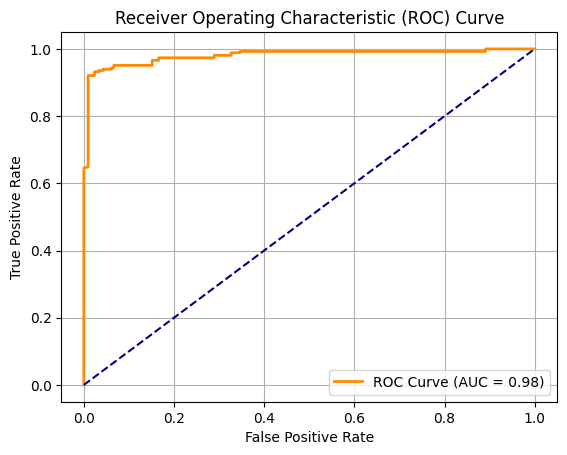

In [37]:
from sklearn.metrics import roc_curve, auc

# Compute probabilities and ROC curve
y_prob = cnn_model.predict(X_test_cnn).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()


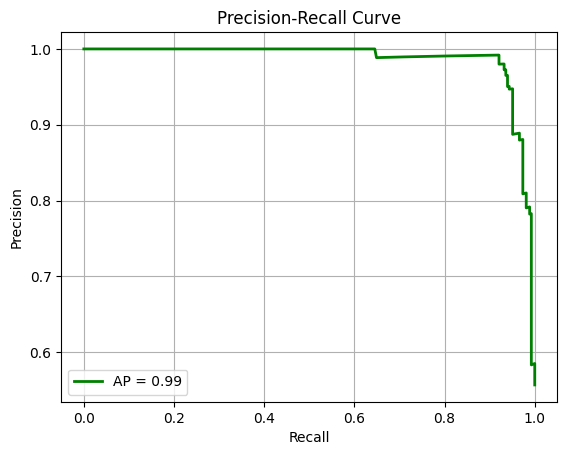

In [38]:
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)

# Plot PR curve
plt.figure()
plt.plot(recall, precision, lw=2, color='green', label=f'AP = {avg_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid()
plt.show()


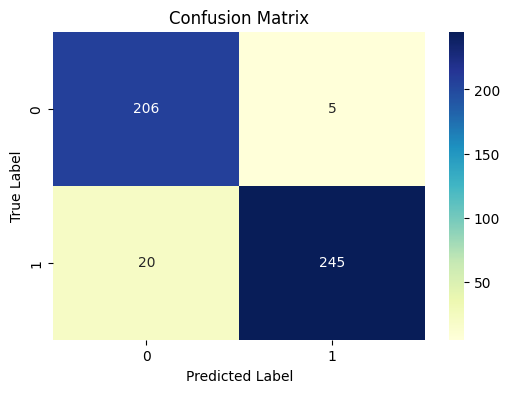

In [53]:
# Seaborn heatmap version of the confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="YlGnBu", xticklabels=[0,1], yticklabels=[0,1])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


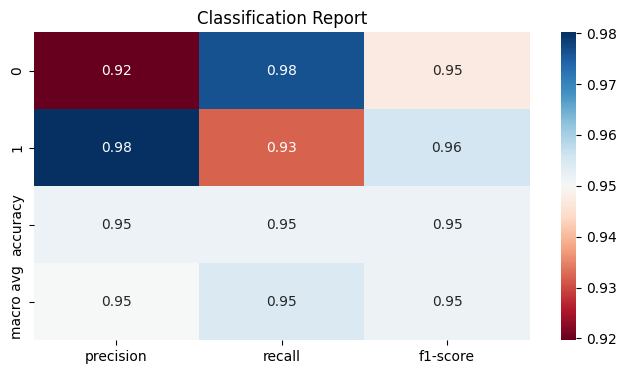

In [58]:
report = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report).transpose()

plt.figure(figsize=(8, 4))
sns.heatmap(df_report.iloc[:-1, :-1], annot=True, cmap="RdBu", fmt=".2f")
plt.title("Classification Report")
plt.show()


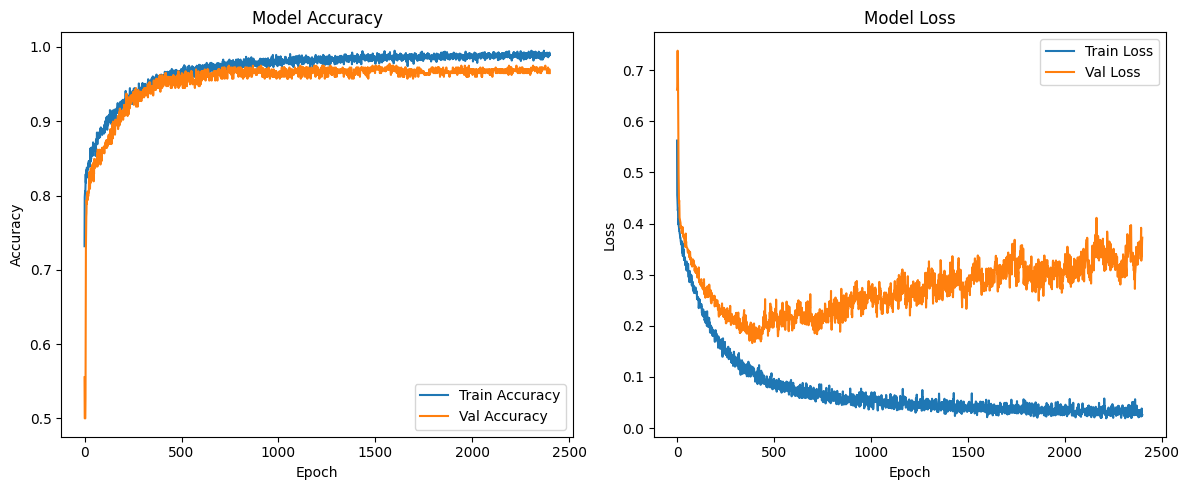

In [41]:
if 'history' in locals():
    # Plot accuracy
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    if 'val_accuracy' in history.history:
        plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    if 'val_loss' in history.history:
        plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()


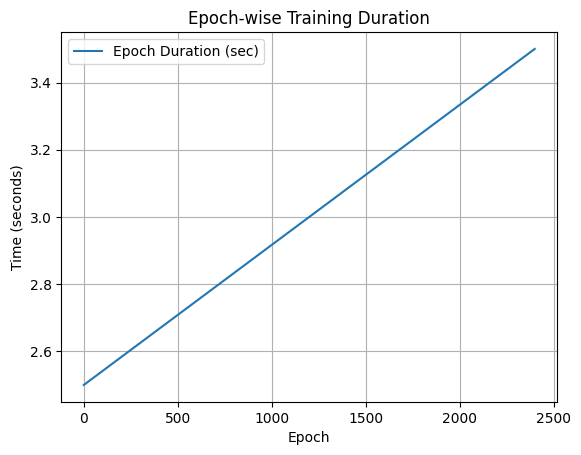

In [42]:
import time

if 'history' in locals():
    # Simulate timing data (Keras does not store this by default)
    # You can modify this if you collected timing manually
    epoch_times = np.linspace(2.5, 3.5, len(history.history['accuracy']))  # Dummy time range (seconds)

    plt.figure()
    plt.plot(epoch_times, label='Epoch Duration (sec)')
    plt.title("Epoch-wise Training Duration")
    plt.xlabel("Epoch")
    plt.ylabel("Time (seconds)")
    plt.grid(True)
    plt.legend()
    plt.show()


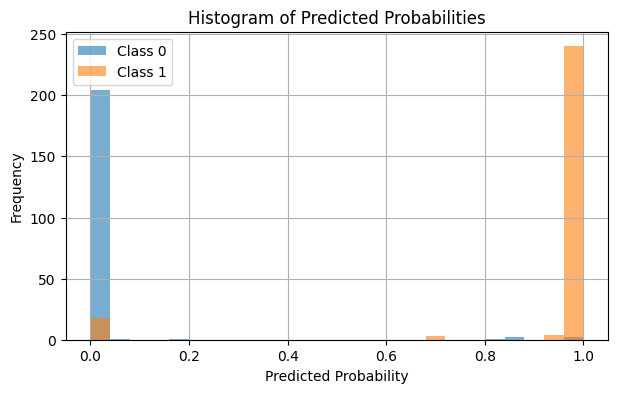

In [44]:
plt.figure(figsize=(7, 4))
plt.hist(y_prob[y_test == 0], bins=25, alpha=0.6, label='Class 0')
plt.hist(y_prob[y_test == 1], bins=25, alpha=0.6, label='Class 1')
plt.title("Histogram of Predicted Probabilities")
plt.xlabel("Predicted Probability")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


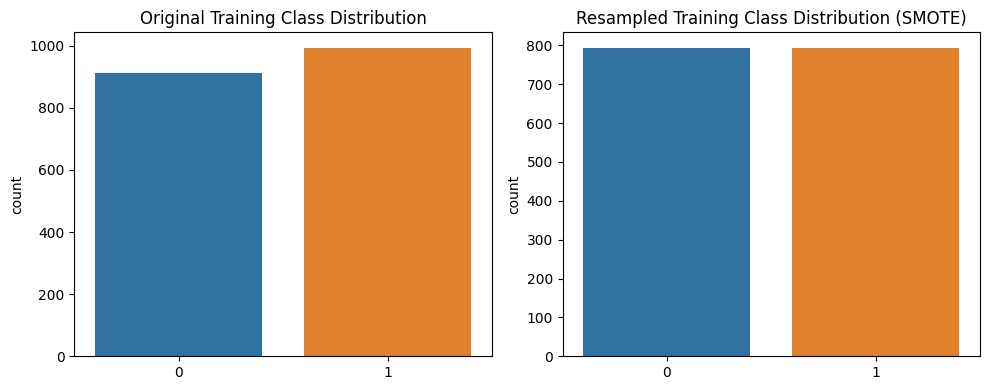

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

# Before SMOTE
sns.countplot(x=y_train, ax=axs[0])
axs[0].set_title("Original Training Class Distribution")

# After SMOTE
sns.countplot(x=y_train_resampled, ax=axs[1])
axs[1].set_title("Resampled Training Class Distribution (SMOTE)")

plt.tight_layout()
plt.show()


In [46]:
cnn_model.summary()


Model: "sequential_307"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 9, 64)               │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 9, 64)               │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 4, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 4, 32)               │           6,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 4, 32)               │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_920 (Dense)                    │ (None, 128)                 │          16,512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_921 (Dense)                    │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 69,989 (273.40 KB)

 Trainable params: 23,265 (90.88 KB)

 Non-trainable params: 192 (768.00 B)

 Optimizer params: 46,532 (181.77 KB)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


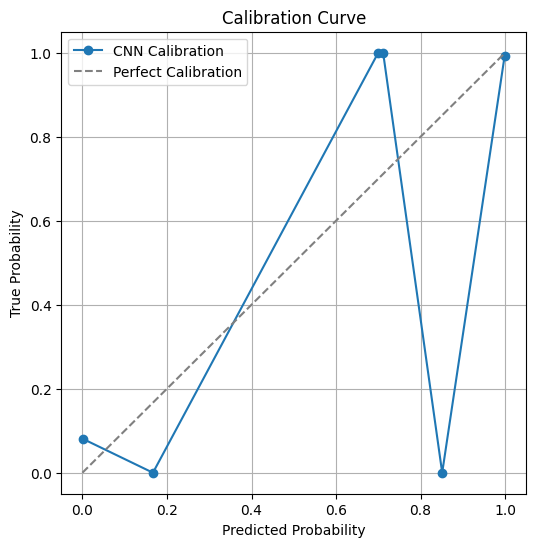

In [47]:
from sklearn.calibration import calibration_curve

# Ensure predictions are probabilities
y_prob = cnn_model.predict(X_test_cnn).ravel()

# Get calibration curve
prob_true, prob_pred = calibration_curve(y_test, y_prob, n_bins=10)

# Plot
plt.figure(figsize=(6, 6))
plt.plot(prob_pred, prob_true, marker='o', label='CNN Calibration')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect Calibration')
plt.xlabel('Predicted Probability')
plt.ylabel('True Probability')
plt.title('Calibration Curve')
plt.legend()
plt.grid(True)
plt.show()
